The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 深度卷积神经网络（AlexNet）
:label:`sec_alexnet`

在LeNet提出后，卷积神经网络在计算机视觉和机器学习领域中很有名气。但卷积神经网络并没有主导这些领域。这是因为虽然LeNet在小数据集上取得了很好的效果，但是在更大、更真实的数据集上训练卷积神经网络的性能和可行性还有待研究。事实上，在上世纪90年代初到2012年之间的大部分时间里，神经网络往往被其他机器学习方法超越，如支持向量机（support vector machines）。

在计算机视觉中，直接将神经网络与其他机器学习方法进行比较也许不公平。这是因为，卷积神经网络的输入是由原始像素值或是经过简单预处理（例如居中、缩放）的像素值组成的。但在使用传统机器学习方法时，从业者永远不会将原始像素作为输入。在传统机器学习方法中，计算机视觉流水线是由经过人的手工精心设计的特征流水线组成的。对于这些传统方法，大部分的进展都来自于对特征有了更聪明的想法，并且学习到的算法往往归于事后的解释。

虽然上世纪90年代就有了一些神经网络加速卡，但仅靠它们还不足以开发出有大量参数的深层多通道多层卷积神经网络。此外，当时的数据集仍然相对较小。除了这些障碍，训练神经网络的一些关键技巧仍然缺失，包括启发式参数初始化、随机梯度下降的变体、非挤压激活函数和有效的正则化技术。

因此，与训练*端到端*（从像素到分类结果）系统不同，经典机器学习的流水线看起来更像下面这样：

1. 获取一个有趣的数据集。在早期，收集这些数据集需要昂贵的传感器（在当时最先进的图像也就100万像素）。
2. 根据光学、几何学、其他知识以及偶然的发现，手工对特征数据集进行预处理。
3. 通过标准的特征提取算法，如SIFT（尺度不变特征变换） :cite:`Lowe.2004`和SURF（加速鲁棒特征） :cite:`Bay.Tuytelaars.Van-Gool.2006`或其他手动调整的流水线来输入数据。
4. 将提取的特征送入最喜欢的分类器中（例如线性模型或其它核方法），以训练分类器。

如果你和机器学习研究人员交谈，你会发现他们相信机器学习既重要又美丽：优雅的理论去证明各种模型的性质。机器学习是一个正在蓬勃发展、严谨且非常有用的领域。然而，如果你和计算机视觉研究人员交谈，你会听到一个完全不同的故事。他们会告诉你图像识别的诡异事实————推动领域进步的是数据特征，而不是学习算法。计算机视觉研究人员相信，从对最终模型精度的影响来说，更大或更干净的数据集、或是稍微改进的特征提取，比任何学习算法带来的进步要大得多。

## 学习表征

另一种预测这个领域发展的方法————观察图像特征的提取方法。在2012年前，图像特征都是机械地计算出来的。事实上，设计一套新的特征函数、改进结果，并撰写论文是盛极一时的潮流。SIFT :cite:`Lowe.2004`、SURF :cite:`Bay.Tuytelaars.Van-Gool.2006`、HOG（定向梯度直方图） :cite:`Dalal.Triggs.2005`、[bags of visual words](https://en.wikipedia.org/wiki/Bag-of-words_model_in_computer_vision)和类似的特征提取方法占据了主导地位。

另一组研究人员，包括Yann LeCun、Geoff Hinton、Yoshua Bengio、Andrew Ng、Shun ichi Amari和Juergen Schmidhuber，想法则与众不同：他们认为特征本身应该被学习。此外，他们还认为，在合理地复杂性前提下，特征应该由多个共同学习的神经网络层组成，每个层都有可学习的参数。在机器视觉中，最底层可能检测边缘、颜色和纹理。事实上，Alex Krizhevsky、Ilya Sutskever和Geoff Hinton提出了一种新的卷积神经网络变体*AlexNet*。在2012年ImageNet挑战赛中取得了轰动一时的成绩。AlexNet以Alex Krizhevsky的名字命名，他是论文 :cite:`Krizhevsky.Sutskever.Hinton.2012`的第一作者。

有趣的是，在网络的最底层，模型学习到了一些类似于传统滤波器的特征抽取器。 :numref:`fig_filters`是从AlexNet论文 :cite:`Krizhevsky.Sutskever.Hinton.2012`复制的，描述了底层图像特征。

![AlexNet第一层学习到的特征抽取器。](../img/filters.png)
:width:`400px`
:label:`fig_filters`

AlexNet的更高层建立在这些底层表示的基础上，以表示更大的特征，如眼睛、鼻子、草叶等等。而更高的层可以检测整个物体，如人、飞机、狗或飞盘。最终的隐藏神经元可以学习图像的综合表示，从而使属于不同类别的数据易于区分。尽管一直有一群执着的研究者不断钻研，试图学习视觉数据的逐级表征，然而很长一段时间里这些尝试都未有突破。深度卷积神经网络的突破出现在2012年。突破可归因于两个关键因素。

### 缺少的成分：数据

包含许多特征的深度模型需要大量的有标签数据，才能显著优于基于凸优化的传统方法（如线性方法和核方法）。
然而，限于早期计算机有限的存储和90年代有限的研究预算，大部分研究只基于小的公开数据集。例如，不少研究论文基于加州大学欧文分校（UCI）提供的若干个公开数据集，其中许多数据集只有几百至几千张在非自然环境下以低分辨率拍摄的图像。这一状况在2010年前后兴起的大数据浪潮中得到改善。2009年，ImageNet数据集发布，并发起ImageNet挑战赛：要求研究人员从100万个样本中训练模型，以区分1000个不同类别的对象。ImageNet数据集由斯坦福教授李飞飞小组的研究人员开发，利用谷歌图像搜索（Google Image Search）对每一类图像进行预筛选，并利用亚马逊众包（Amazon Mechanical Turk）来标注每张图片的相关类别。这种规模是前所未有的。这项被称为ImageNet的挑战赛推动了计算机视觉和机器学习研究的发展，挑战研究人员确定哪些模型能够在更大的数据规模下表现最好。

### 缺少的成分：硬件

深度学习对计算资源要求很高，训练可能需要数百个迭代轮数，每次迭代都需要通过代价高昂的许多线性代数层传递数据。这也是为什么在20世纪90年代至21世纪初，优化凸目标的简单算法是研究人员的首选。然而，用GPU训练神经网络改变了这一格局。*图形处理器*（Graphics Processing Unit，GPU）早年用来加速图形处理，使电脑游戏玩家受益。GPU可优化高吞吐量的$4 \times 4$矩阵和向量乘法，从而服务于基本的图形任务。幸运的是，这些数学运算与卷积层的计算惊人地相似。由此，英伟达（NVIDIA）和ATI已经开始为通用计算操作优化gpu，甚至把它们作为*通用GPU*（general-purpose GPUs，GPGPU）来销售。

那么GPU比CPU强在哪里呢？

首先，我们深度理解一下中央处理器（Central Processing Unit，CPU）的*核心*。
CPU的每个核心都拥有高时钟频率的运行能力，和高达数MB的三级缓存（L3Cache）。
它们非常适合执行各种指令，具有分支预测器、深层流水线和其他使CPU能够运行各种程序的功能。
然而，这种明显的优势也是它的致命弱点：通用核心的制造成本非常高。
它们需要大量的芯片面积、复杂的支持结构（内存接口、内核之间的缓存逻辑、高速互连等等），而且它们在任何单个任务上的性能都相对较差。
现代笔记本电脑最多有4核，即使是高端服务器也很少超过64核，因为它们的性价比不高。

相比于CPU，GPU由$100 \sim 1000$个小的处理单元组成（NVIDIA、ATI、ARM和其他芯片供应商之间的细节稍有不同），通常被分成更大的组（NVIDIA称之为warps）。
虽然每个GPU核心都相对较弱，有时甚至以低于1GHz的时钟频率运行，但庞大的核心数量使GPU比CPU快几个数量级。
例如，NVIDIA最近一代的Ampere GPU架构为每个芯片提供了高达312 TFlops的浮点性能，而CPU的浮点性能到目前为止还没有超过1 TFlops。
之所以有如此大的差距，原因其实很简单：首先，功耗往往会随时钟频率呈二次方增长。
对于一个CPU核心，假设它的运行速度比GPU快4倍，你可以使用16个GPU内核取代，那么GPU的综合性能就是CPU的$16 \times 1/4 = 4$倍。
其次，GPU内核要简单得多，这使得它们更节能。
此外，深度学习中的许多操作需要相对较高的内存带宽，而GPU拥有10倍于CPU的带宽。

回到2012年的重大突破，当Alex Krizhevsky和Ilya Sutskever实现了可以在GPU硬件上运行的深度卷积神经网络时，一个重大突破出现了。他们意识到卷积神经网络中的计算瓶颈：卷积和矩阵乘法，都是可以在硬件上并行化的操作。
于是，他们使用两个显存为3GB的NVIDIA GTX580 GPU实现了快速卷积运算。他们的创新[cuda-convnet](https://code.google.com/archive/p/cuda-convnet/)几年来它一直是行业标准，并推动了深度学习热潮。

## AlexNet

2012年，AlexNet横空出世。它首次证明了学习到的特征可以超越手工设计的特征。它一举打破了计算机视觉研究的现状。
AlexNet使用了8层卷积神经网络，并以很大的优势赢得了2012年ImageNet图像识别挑战赛。

AlexNet和LeNet的架构非常相似，如 :numref:`fig_alexnet`所示。
注意，这里我们提供了一个稍微精简版本的AlexNet，去除了当年需要两个小型GPU同时运算的设计特点。

![从LeNet（左）到AlexNet（右）](http://d2l.ai/_images/alexnet.svg)
:label:`fig_alexnet`

AlexNet和LeNet的设计理念非常相似，但也存在显著差异。
首先，AlexNet比相对较小的LeNet5要深得多。
AlexNet由八层组成：五个卷积层、两个全连接隐藏层和一个全连接输出层。
其次，AlexNet使用ReLU而不是sigmoid作为其激活函数。
下面，让我们深入研究AlexNet的细节。

### 模型设计

在AlexNet的第一层，卷积窗口的形状是$11\times11$。
由于ImageNet中大多数图像的宽和高比MNIST图像的多10倍以上，因此，需要一个更大的卷积窗口来捕获目标。
第二层中的卷积窗口形状被缩减为$5\times5$，然后是$3\times3$。
此外，在第一层、第二层和第五层卷积层之后，加入窗口形状为$3\times3$、步幅为2的最大汇聚层。
而且，AlexNet的卷积通道数目是LeNet的10倍。

在最后一个卷积层后有两个全连接层，分别有4096个输出。
这两个巨大的全连接层拥有将近1GB的模型参数。
由于早期GPU显存有限，原版的AlexNet采用了双数据流设计，使得每个GPU只负责存储和计算模型的一半参数。
幸运的是，现在GPU显存相对充裕，所以我们现在很少需要跨GPU分解模型（因此，我们的AlexNet模型在这方面与原始论文稍有不同）。

### 激活函数

此外，AlexNet将sigmoid激活函数改为更简单的ReLU激活函数。
一方面，ReLU激活函数的计算更简单，它不需要如sigmoid激活函数那般复杂的求幂运算。
另一方面，当使用不同的参数初始化方法时，ReLU激活函数使训练模型更加容易。
当sigmoid激活函数的输出非常接近于0或1时，这些区域的梯度几乎为0，因此反向传播无法继续更新一些模型参数。
相反，ReLU激活函数在正区间的梯度总是1。
因此，如果模型参数没有正确初始化，sigmoid函数可能在正区间内得到几乎为0的梯度，从而使模型无法得到有效的训练。

### 容量控制和预处理

AlexNet通过暂退法（ :numref:`sec_dropout`）控制全连接层的模型复杂度，而LeNet只使用了权重衰减。
为了进一步扩充数据，AlexNet在训练时增加了大量的图像增强数据，如翻转、裁切和变色。
这使得模型更健壮，更大的样本量有效地减少了过拟合。
我们将在 :numref:`sec_image_augmentation`中更详细地讨论数据扩增。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    # 这里，我们使用一个11*11的更大窗口来捕捉对象。
    # 同时，步幅为4，以减少输出的高度和宽度。
    # 另外，输出通道的数目远大于LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致，且增大输出通道数
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 使用三个连续的卷积层和较小的卷积窗口。
    # 除了最后的卷积层，输出通道的数量进一步增加。
    # 在前两个卷积层之后，汇聚层不用于减少输入的高度和宽度
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # 这里，全连接层的输出数量是LeNet中的好几倍。使用dropout层来减轻过拟合
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # 最后是输出层。由于这里使用Fashion-MNIST，所以用类别数为10，而非论文中的1000
    nn.Linear(4096, 10))

[**我们构造一个**]高度和宽度都为224的(**单通道数据，来观察每一层输出的形状**)。
它与 :numref:`fig_alexnet`中的AlexNet架构相匹配。


In [2]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

## 读取数据集

尽管本文中AlexNet是在ImageNet上进行训练的，但我们在这里使用的是Fashion-MNIST数据集。因为即使在现代GPU上，训练ImageNet模型，同时使其收敛可能需要数小时或数天的时间。
将AlexNet直接应用于Fashion-MNIST的一个问题是，[**Fashion-MNIST图像的分辨率**]（$28 \times 28$像素）(**低于ImageNet图像。**)
为了解决这个问题，(**我们将它们增加到$224 \times 224$**)（通常来讲这不是一个明智的做法，但我们在这里这样做是为了有效使用AlexNet架构）。
我们使用`d2l.load_data_fashion_mnist`函数中的`resize`参数执行此调整。


In [3]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

## [**训练AlexNet**]

现在，我们可以开始训练AlexNet了。与 :numref:`sec_lenet`中的LeNet相比，这里的主要变化是使用更小的学习速率训练，这是因为网络更深更广、图像分辨率更高，训练卷积神经网络就更昂贵。


loss 0.333, train acc 0.877, test acc 0.879
4152.2 examples/sec on cuda:0


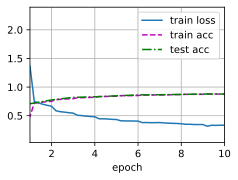

In [4]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* AlexNet的架构与LeNet相似，但使用了更多的卷积层和更多的参数来拟合大规模的ImageNet数据集。
* 今天，AlexNet已经被更有效的架构所超越，但它是从浅层网络到深层网络的关键一步。
* 尽管AlexNet的代码只比LeNet多出几行，但学术界花了很多年才接受深度学习这一概念，并应用其出色的实验结果。这也是由于缺乏有效的计算工具。
* Dropout、ReLU和预处理是提升计算机视觉任务性能的其他关键步骤。

## 练习

1. 试着增加迭代轮数。对比LeNet的结果有什么不同？为什么？
1. AlexNet对于Fashion-MNIST数据集来说可能太复杂了。
    1. 尝试简化模型以加快训练速度，同时确保准确性不会显著下降。
    1. 设计一个更好的模型，可以直接在$28 \times 28$图像上工作。
1. 修改批量大小，并观察模型精度和GPU显存变化。
1. 分析了AlexNet的计算性能。
    1. 在AlexNet中主要是哪部分占用显存？
    1. 在AlexNet中主要是哪部分需要更多的计算？
    1. 计算结果时显存带宽如何？
1. 将dropout和ReLU应用于LeNet-5，效果有提升吗？再试试预处理会怎么样？


[Discussions](https://discuss.d2l.ai/t/1863)
